# Capsule Networks for Image and Text Classification Problems

# Our project source code can be found at <a href="https://github.com/SakshamM28/Capsule_Network" target="_blank">this GitHub link</a> (check different dev branches). 

## 1. Load and visualize different datasets

In [134]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np

In [190]:
from Modules import DatasetHelper, Helper
from Modules_CNN import DatasetHelper as DatasetHelper_CNN
from matplotlib import pyplot as plt

In [136]:
# some initializations
helper = Helper()

### 1.1. MNIST Dataset

Similar to the original CapsNet paper, we apply random augmentation in the form of random shift upto 2 pixels in each direction. We apply on-the-fly augmentation using `transformData_MNIST()` in Modules.py

In [137]:
mnist_train_loader = torch.utils.data.DataLoader(DatasetHelper.getDataSet(isTrain=True), batch_size=2, shuffle=True)

Label: 6


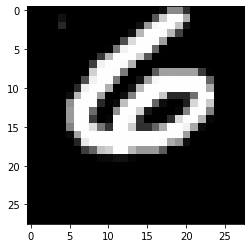

Label: 6


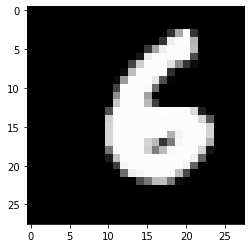

Label: 0


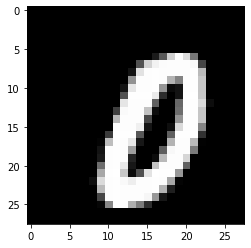

In [138]:
count=0
for batch_idx, (data, target) in enumerate(mnist_train_loader):
    data = helper.transformData_MNIST(data, batch_size=2) # randomly shift upto 2 pixels in each direction
    print('Label:', target[0].numpy())
    plt.imshow(np.squeeze(data[0].numpy()), cmap='gray')
    plt.show()
    count+=1
    if count>2: break

### 1.2. Shifted MNIST Dataset

This dataset is padded and translated MNIST dataset in which each digit is randomly paced in a 40x40 black image.
For our training, we generate samples of this dataset on-the-fly (during training) using `transformData_ShiftedMNIST()` in Modules.py

Label: 1


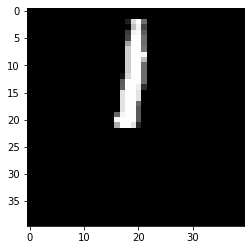

Label: 1


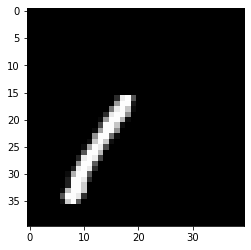

Label: 1


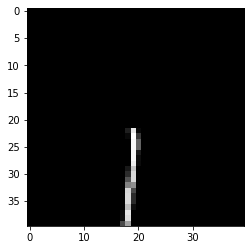

In [139]:
count=0
for batch_idx, (data, target) in enumerate(mnist_train_loader):
    data = helper.transformData_ShiftedMNIST(data, batch_size=2) # randomly shift upto 2 pixels in each direction
    print('Label:', target[0].numpy())
    plt.imshow(np.squeeze(data[0].numpy()), cmap='gray')
    plt.show()
    count+=1
    if count>2: break

### 1.3. MultiMNIST Dataset

This dataset aims to test the model's capability to segment multiple digits that are even overlapping with each other. We created our own Dataloader `MultiMNIST_Dataloader` and data generation routines to generate images containing overlapping digits from the MNIST dataset.

In contrast, the original CapsNet paper generates and saves 60M samples which becomes a bit difficult to manage.

In [143]:
from MultiMNIST_Dataloader import MultiMNIST_Dataloader

In [144]:
train_loader = torch.utils.data.DataLoader(MultiMNIST_Dataloader(is_train=False), batch_size=1)

Merged image:


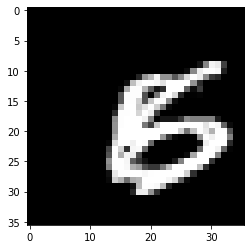

Base (shifted) image, label is:  5


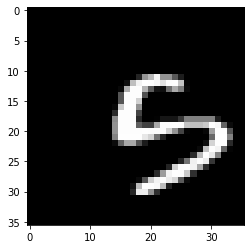

Top (shifted) image, label is: 6


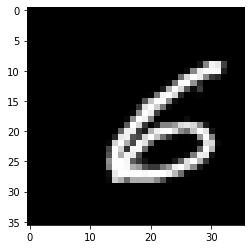

In [145]:
count=0
for batch_idx, (merged, base_shifted, top_shifted, base_label, top_label) in enumerate(train_loader):
    print('Merged image:')
    plt.imshow(np.squeeze(merged[0].numpy()), cmap='gray')
    plt.show()
    
    print('Base (shifted) image, label is: ', base_label[0].numpy())
    plt.imshow(np.squeeze(base_shifted[0].numpy()), cmap='gray')
    plt.show()
    
    print('Top (shifted) image, label is:', top_label[0].numpy())
    plt.imshow(np.squeeze(top_shifted[0].numpy()), cmap='gray')
    plt.show()
    
    count+=1
    if count>0: break 

## 2. Visualize training curves, output and results

In [160]:
from IPython.display import Image, display

### 2.1. MNIST Dataset

#### 2.1.1. CapsNet

First we visulize the train curves:

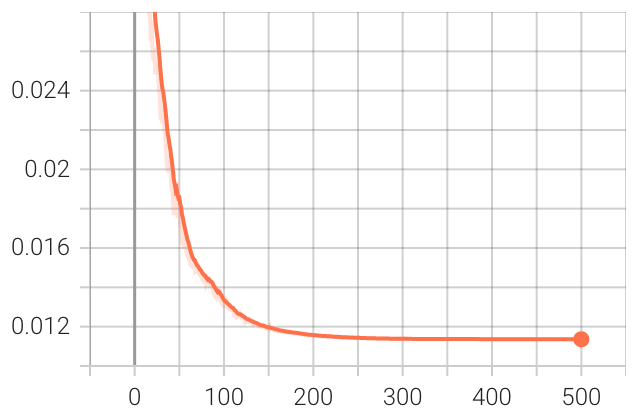

1. CapsNet train loss


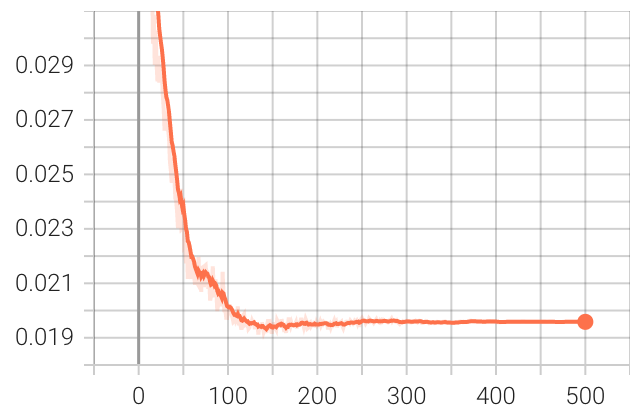

2. CapsNet eval loss


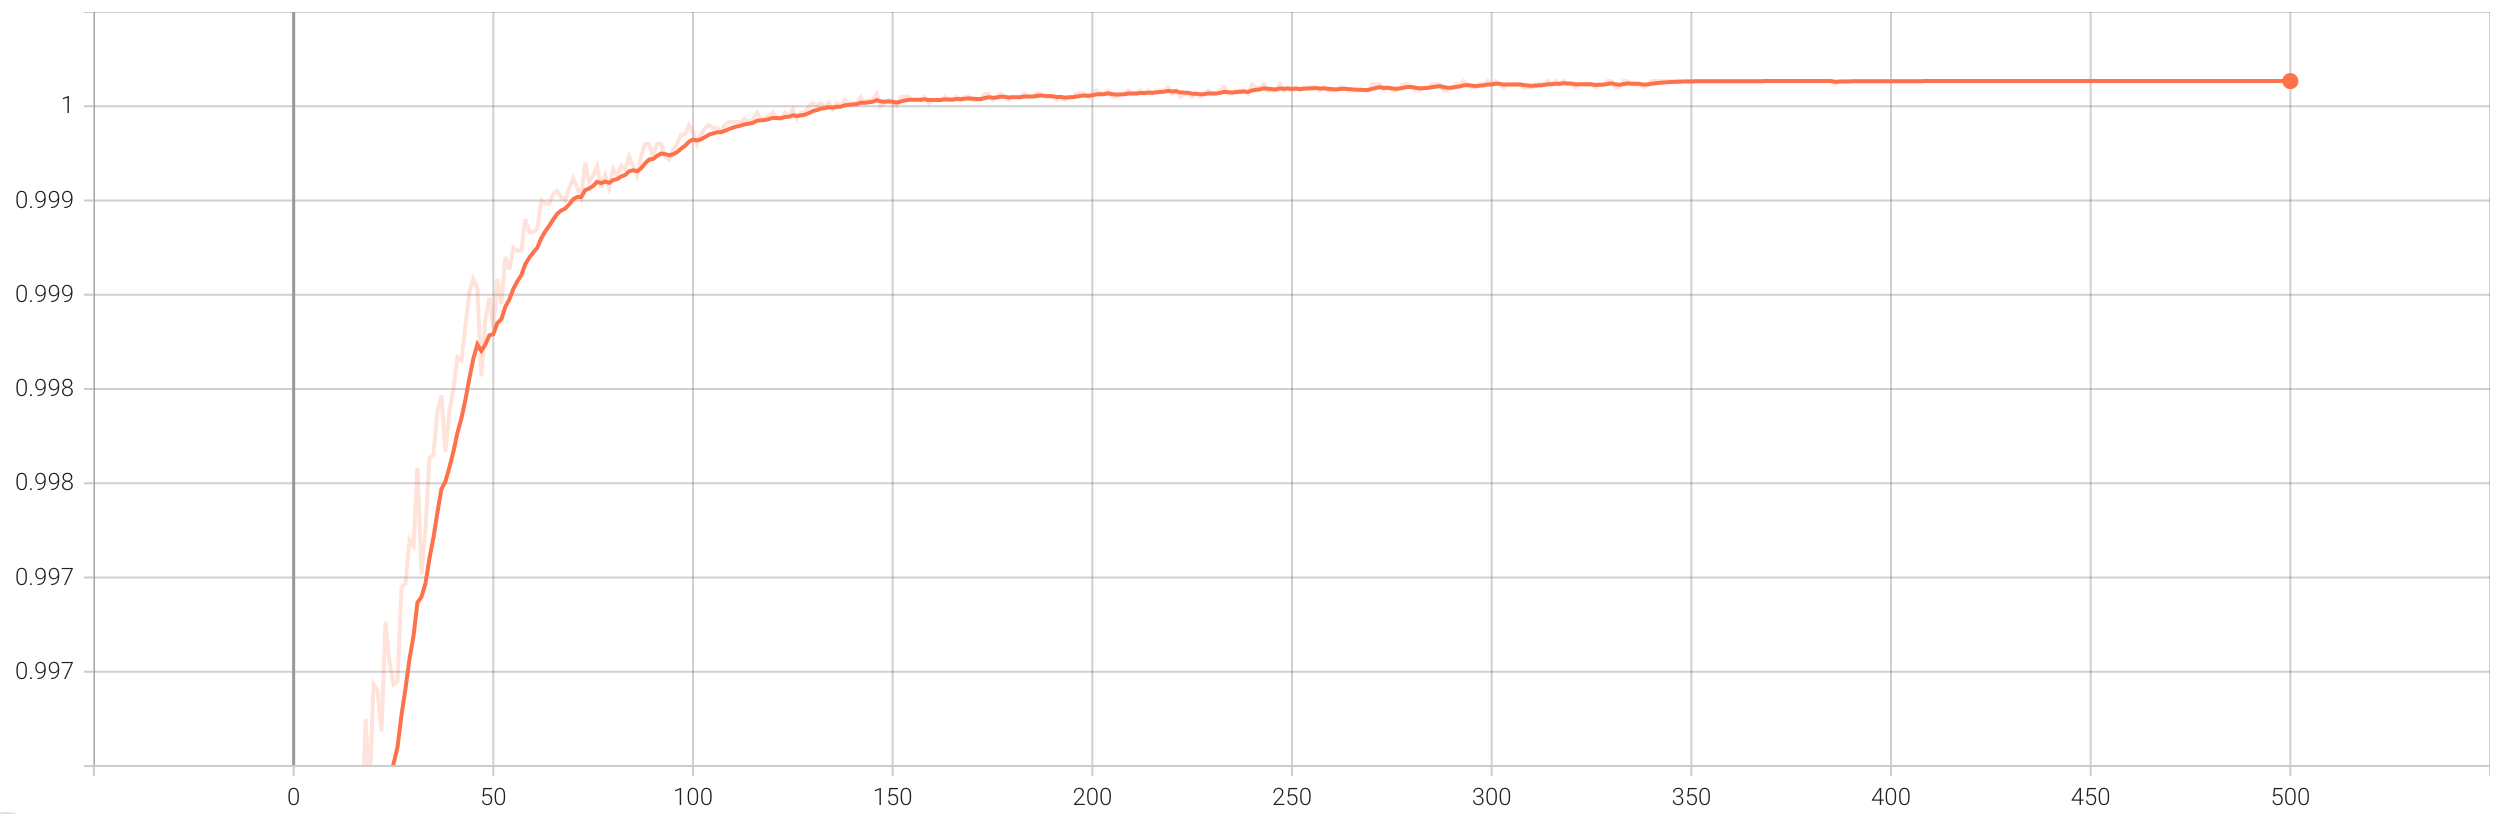

3. CapsNet train accuracy


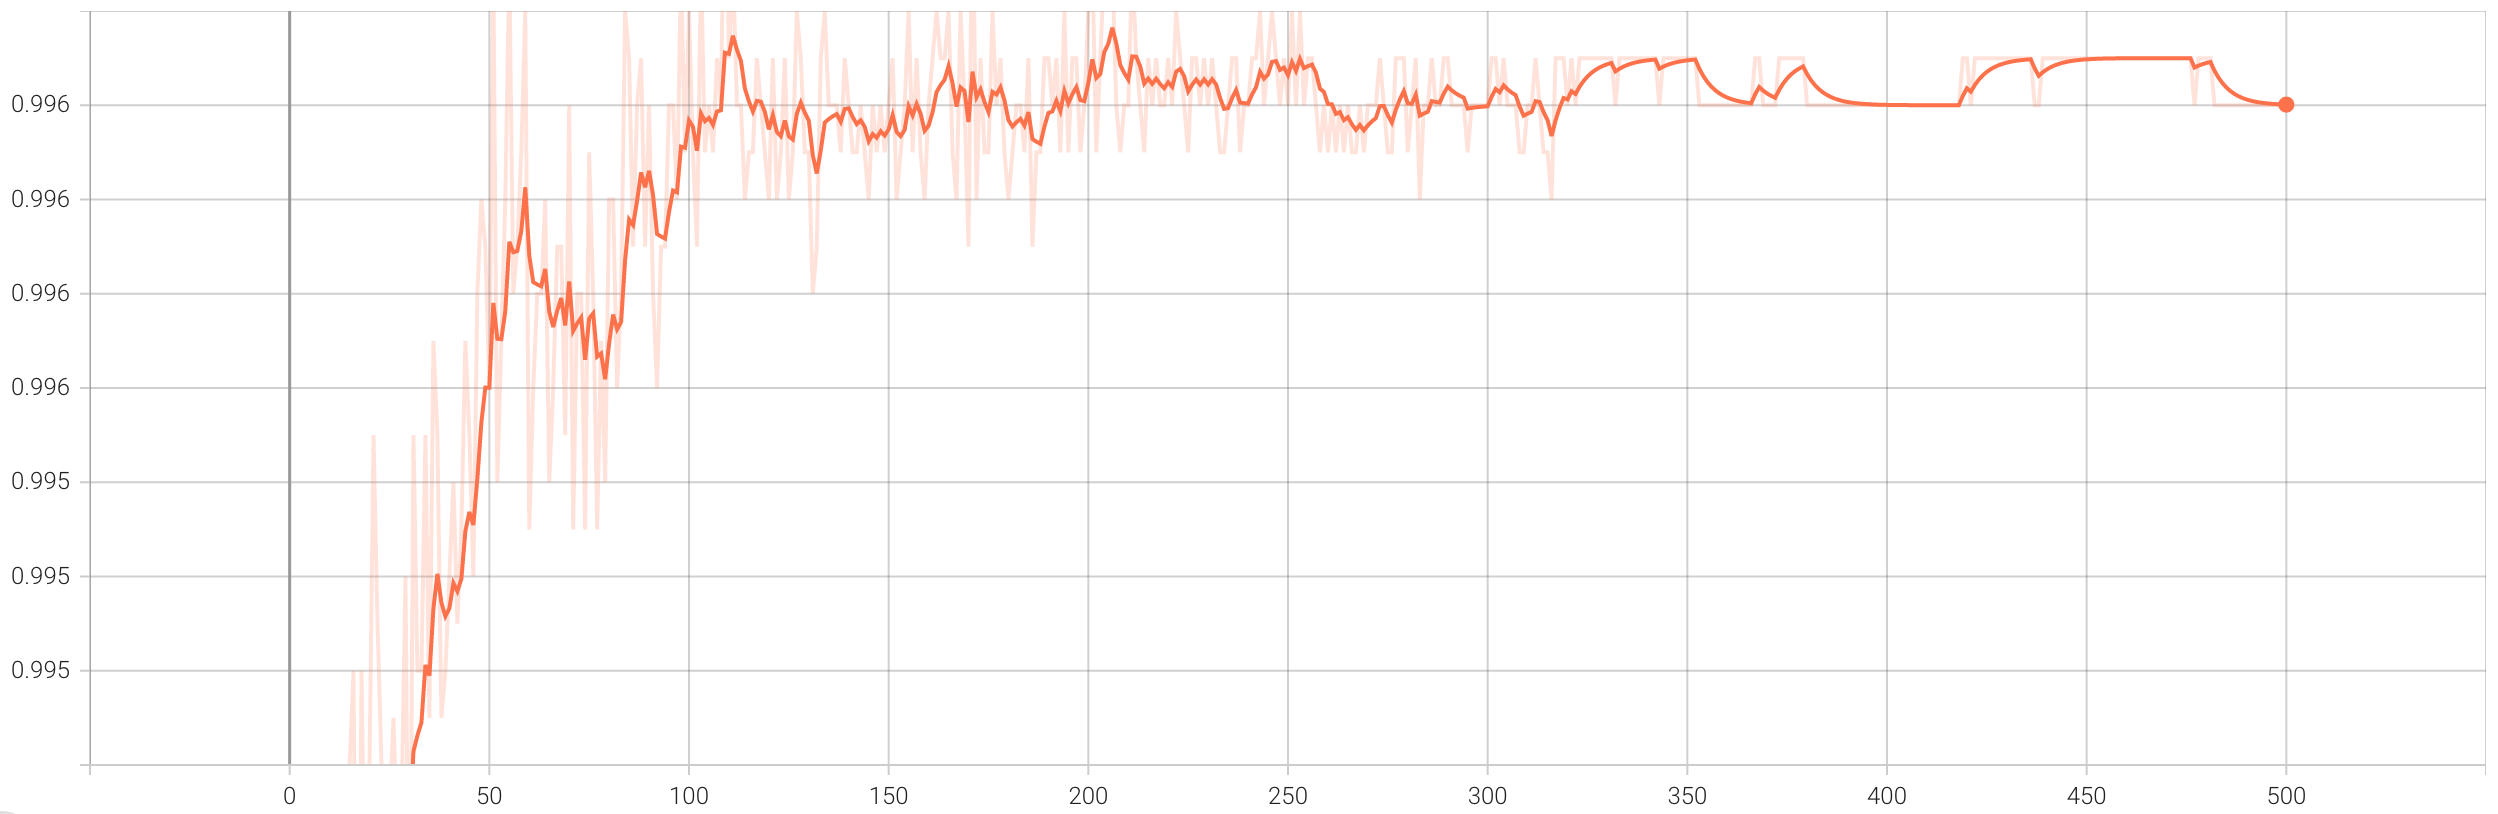

4. CapsNet test accuracy


In [159]:
display(Image('./Data/train_curves/mnist_train_loss_128.png', height=256, width=256))
print('1. CapsNet train loss')
display(Image('./Data/train_curves/mnist_eval_loss_128.png', height=256, width=256))
print('2. CapsNet eval loss')
display(Image('./Data/train_curves/mnist_train_acc_128.png', height=384, width=768))
print('3. CapsNet train accuracy')
display(Image('./Data/train_curves/mnist_test_acc_128.png', height=384, width=768))
print('4. CapsNet test accuracy')

Now we prepare to load and evaluate the model on MNIST test dataset

In [192]:
if torch.cuda.is_available():
    dev = torch.device("cuda")
    print("GPU available")
else:
    dev = torch.device("cpu")

In [163]:
# model loading
model_path = 'saved_model/best_models/mnist_128_500/caps_net_mnist_500_109.pt'

# When using DDP, state dict adds module prefix to all parameters, 
# we need to remove these prefixes to load the model in non DDP environment
from collections import OrderedDict
import re

model_dict = OrderedDict()
pattern = re.compile('module.')

state_dict = torch.load(model_path, map_location=torch.device('cpu'))

for k,v in state_dict.items():
    if re.search("module", k):
        model_dict[re.sub(pattern, '', k)] = v
    else:
        model_dict = state_dict

In [173]:
# instantiate model 
from Caps_Net_MNIST_DP import MNISTCapsuleNetworkModel
network = MNISTCapsuleNetworkModel()

# print model params
helper = Helper()
table, total_params = helper.count_parameters(network)
print('CapsNet model:')
print(table)
print('Total trainable parameters: ', total_params)

CapsNet model:
+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
|      conv1.weight     |   20736    |
|       conv1.bias      |    256     |
|      conv2.weight     |  5308416   |
|       conv2.bias      |    256     |
| digit_capsules.weight |  1474560   |
|    decoder.0.weight   |   81920    |
|     decoder.0.bias    |    512     |
|    decoder.2.weight   |   524288   |
|     decoder.2.bias    |    1024    |
|    decoder.4.weight   |   802816   |
|     decoder.4.bias    |    784     |
+-----------------------+------------+
Total trainable parameters:  8215568


In [193]:
# load model weights and evaluate
network.load_state_dict(model_dict)
network.to(dev)
# put network on eval mode
network.eval()

MnistCNN(
  (model): Sequential(
    (conv1): Conv2d(1, 512, kernel_size=(9, 9), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activation1): ReLU()
    (conv2): Conv2d(512, 256, kernel_size=(5, 5), stride=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activation2): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=2304, out_features=1024, bias=True)
    (activation3): ReLU()
    (linear2): Linear(in_features=1024, out_features=10, bias=True)
    (activation4): LogSoftmax(dim=1)
  )
)

In [178]:
# load MNIST test dataset
test_loader = torch.utils.data.DataLoader(DatasetHelper.getDataSet(isTrain=False), batch_size=256)

#evaluate the model
count = 0
wrong_count = 0
for batch_idx, (data, target) in enumerate(test_loader):
    data = data.float()
    data = data.to(dev)
    target = target.to(dev)
    _,reconstructions, preds = network.forward(data)
    count += torch.sum(preds == target).detach().item()
    
accuracy = float(count) / len(test_loader.dataset)
print('CapsNet accuracy on MNIST test set:', accuracy*100, '%')

CapsNet accuracy on MNIST test set: 99.68 %


Original CapsNet accuracy in Sabour et al.'s paper was 99.75%
A very recent paper titled "Efficient-CapsNet: capsule network with self-attention routing" published in Nature Scientific Reports 2021, could obtain max accuracy of 99.64% by replicating Sabour et al.'s paper. 

Quote from the authors:
**"We really did our best, but there is no way to make the network achieve a score greater than 99.64% on MNIST."**

#### 2.1.2. Baseline CNN

First we visulize the train curves:

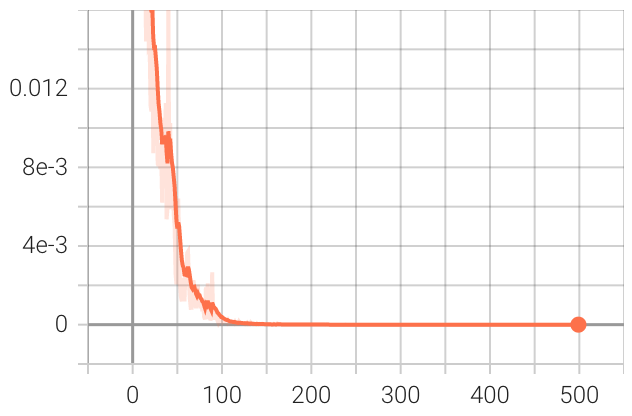

1. CNN train loss


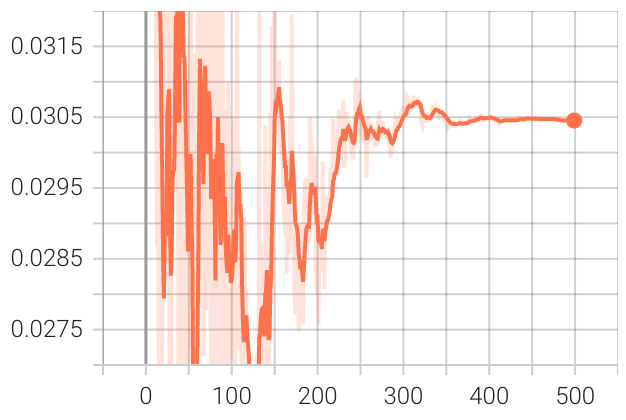

2. CNN eval loss


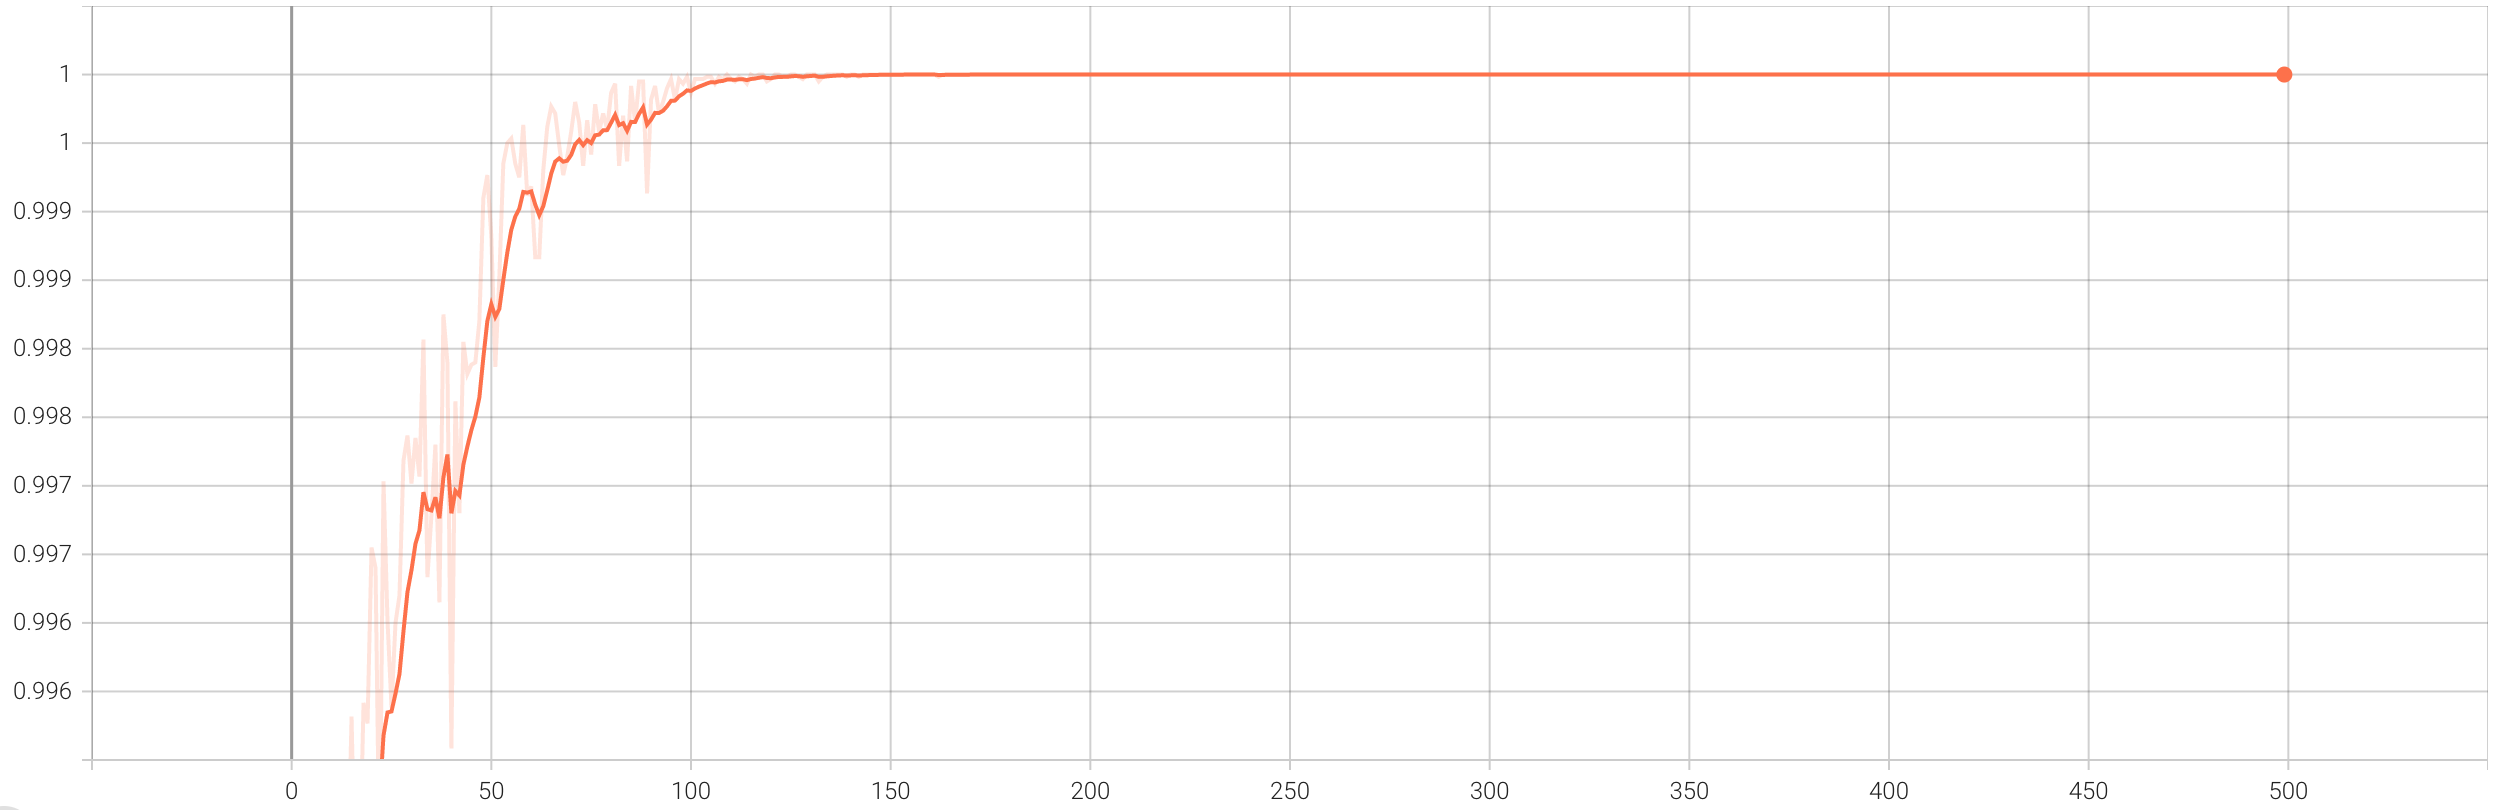

3. CNN train accuracy


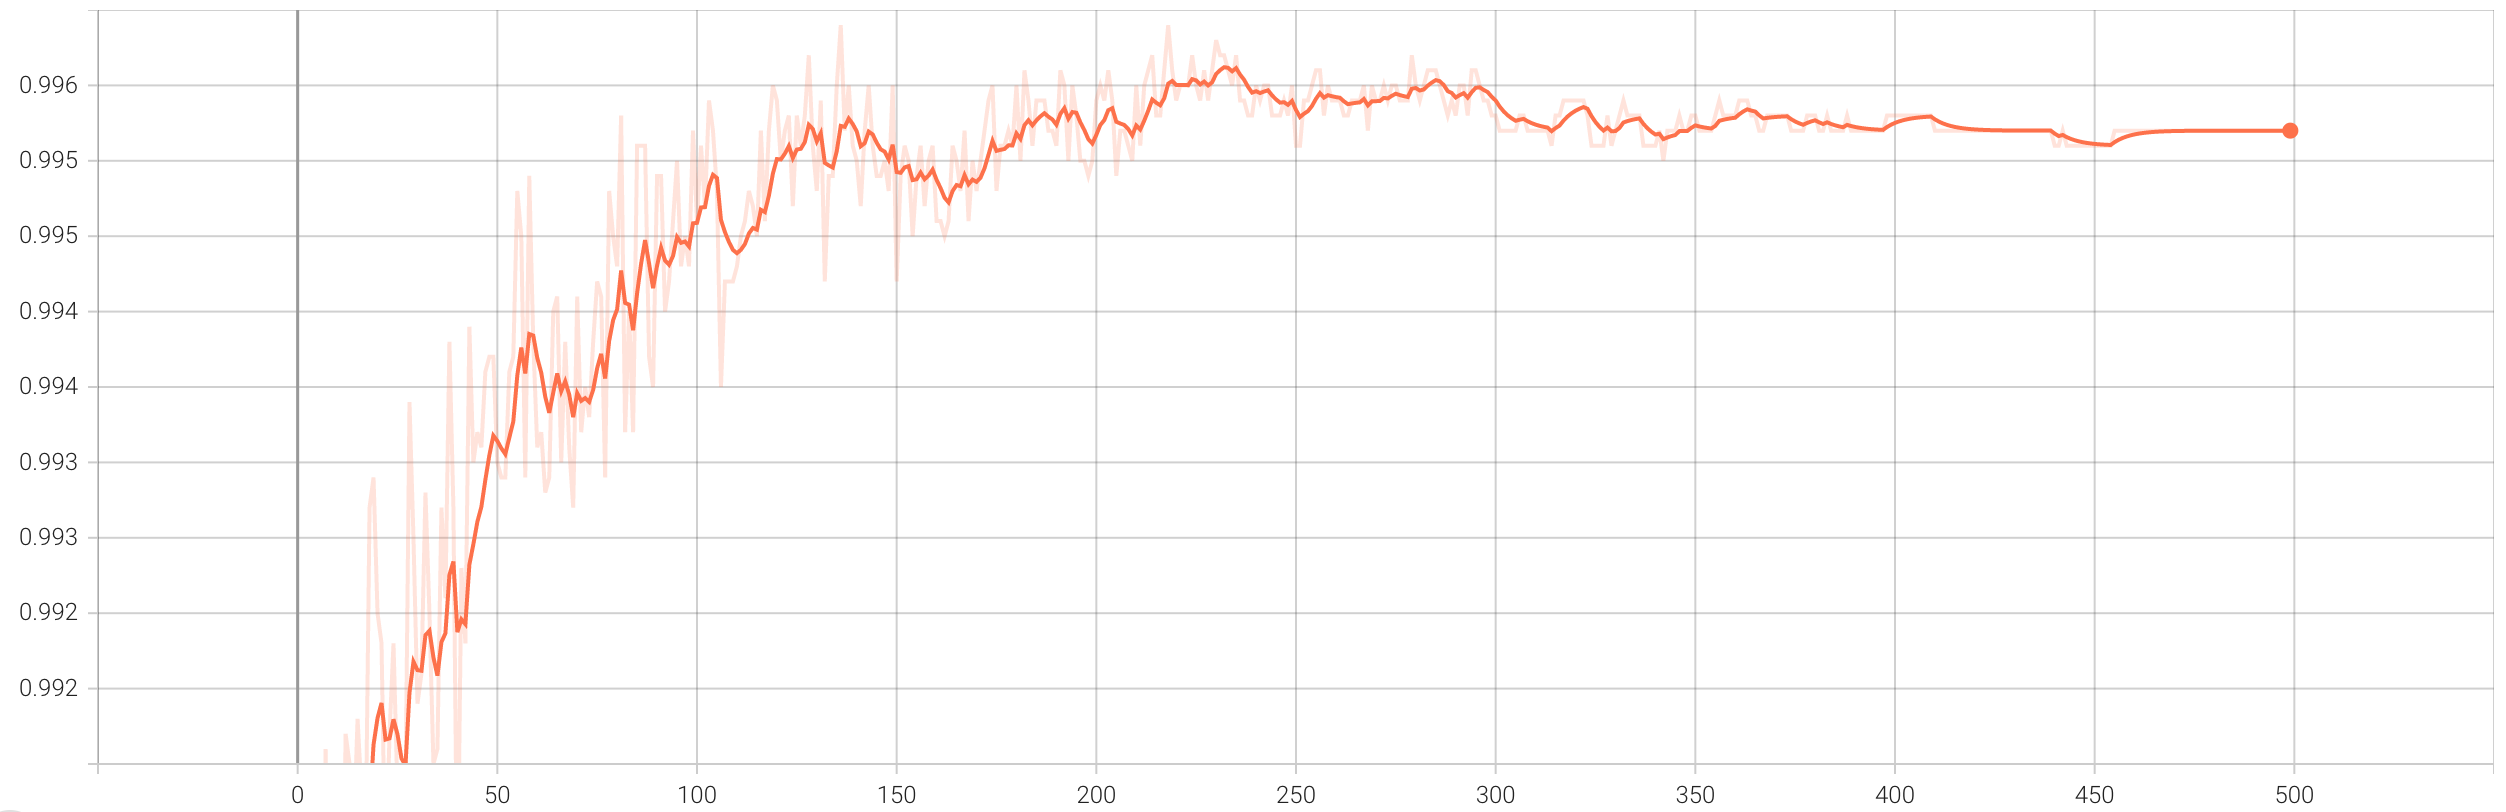

4. CNN test accuracy


In [177]:
display(Image('./Data/train_curves/mnist_cnn_train_loss_128.png', height=256, width=256))
print('1. CNN train loss')
display(Image('./Data/train_curves/mnist_cnn_eval_loss_128.png', height=256, width=256))
print('2. CNN eval loss')
display(Image('./Data/train_curves/mnist_cnn_train_acc_128.png', height=384, width=768))
print('3. CNN train accuracy')
display(Image('./Data/train_curves/mnist_cnn_test_acc_128.png', height=384, width=768))
print('4. CNN test accuracy')

Now we prepare to load and evaluate the model on MNIST test dataset

In [182]:
# model loading
model_path = 'saved_model/best_models/mnist_cnn_128_500/cnn_mnist_500_136.pt'

# When using DDP, state dict adds module prefix to all parameters, 
# we need to remove these prefixes to load the model in non DDP environment
from collections import OrderedDict
import re

model_dict = OrderedDict()
pattern = re.compile('module.')

state_dict = torch.load(model_path, map_location=torch.device('cpu'))

for k,v in state_dict.items():
    if re.search("module", k):
        model_dict[re.sub(pattern, '', k)] = v
    else:
        model_dict = state_dict

In [184]:
# instantiate model 
from CNN_MNIST_DP import MnistCNN
network = MnistCNN()

# print model params
helper = Helper()
table, total_params = helper.count_parameters(network)
print('Baseline CNN model:')
print(table)
print('Total trainable parameters: ', total_params)

Baseline CNN model:
+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
|  model.conv1.weight  |   41472    |
|   model.conv1.bias   |    512     |
|  model.conv2.weight  |  3276800   |
|   model.conv2.bias   |    256     |
| model.linear1.weight |  2359296   |
|  model.linear1.bias  |    1024    |
| model.linear2.weight |   10240    |
|  model.linear2.bias  |     10     |
+----------------------+------------+
Total trainable parameters:  5689610


In [194]:
# load model weights and evaluate
network.load_state_dict(model_dict)
network.to(dev)
# put network on eval mode
network.eval()

MnistCNN(
  (model): Sequential(
    (conv1): Conv2d(1, 512, kernel_size=(9, 9), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activation1): ReLU()
    (conv2): Conv2d(512, 256, kernel_size=(5, 5), stride=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activation2): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=2304, out_features=1024, bias=True)
    (activation3): ReLU()
    (linear2): Linear(in_features=1024, out_features=10, bias=True)
    (activation4): LogSoftmax(dim=1)
  )
)

In [191]:
# load MNIST test dataset
test_loader = torch.utils.data.DataLoader(DatasetHelper_CNN.getDataSet(isTrain=False), batch_size=256)

#evaluate the model
count = 0
wrong_count = 0
for batch_idx, (data, target) in enumerate(test_loader):
    data = data.float()
    data = data.to(dev)
    target = target.to(dev)
    pred = network.forward(data)
    _, preds = torch.max(pred, dim=1)
    count += torch.sum(preds == target).detach().item()
    
accuracy = float(count) / len(test_loader.dataset)
print('Baseline CNN accuracy on MNIST test set:', accuracy*100, '%')

Baseline CNN accuracy on MNIST test set: 99.59 %


### 2.2 Robustness on affNIST Dataset

#### 2.2.1. CapsNet

First we visualize the train curves:

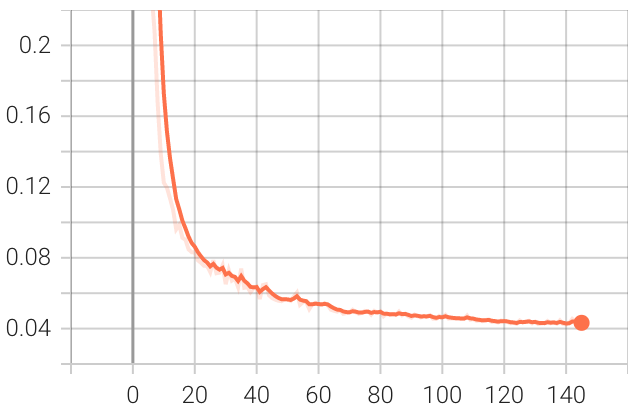

1. CapsNet train loss


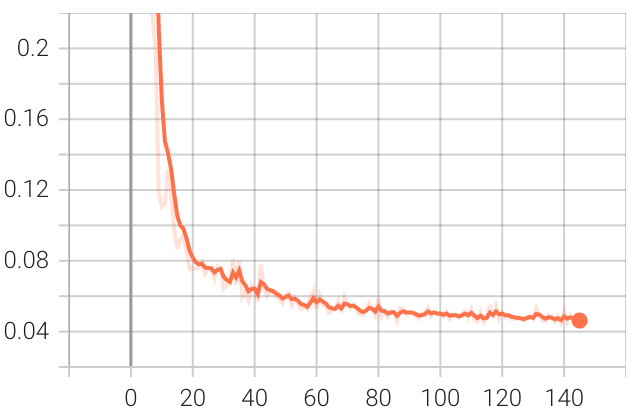

2. CapsNet eval loss


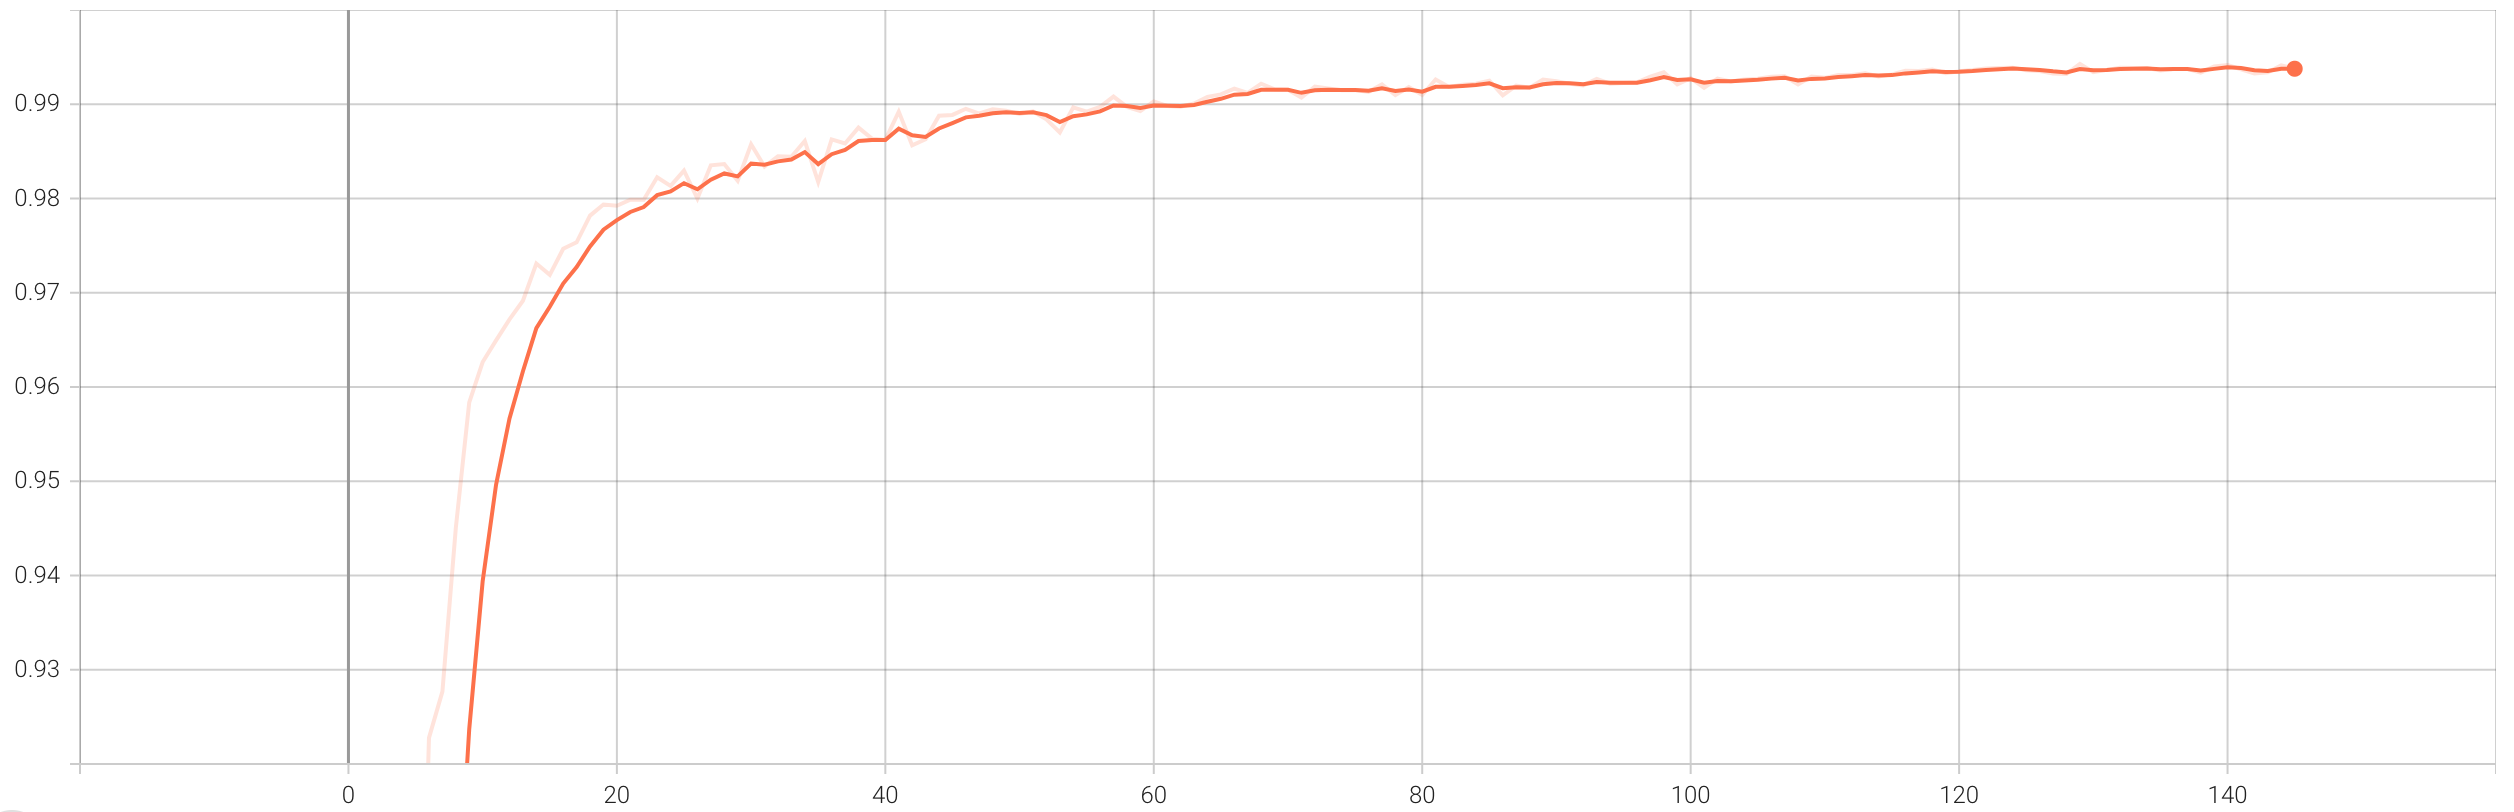

3. CapsNet train accuracy


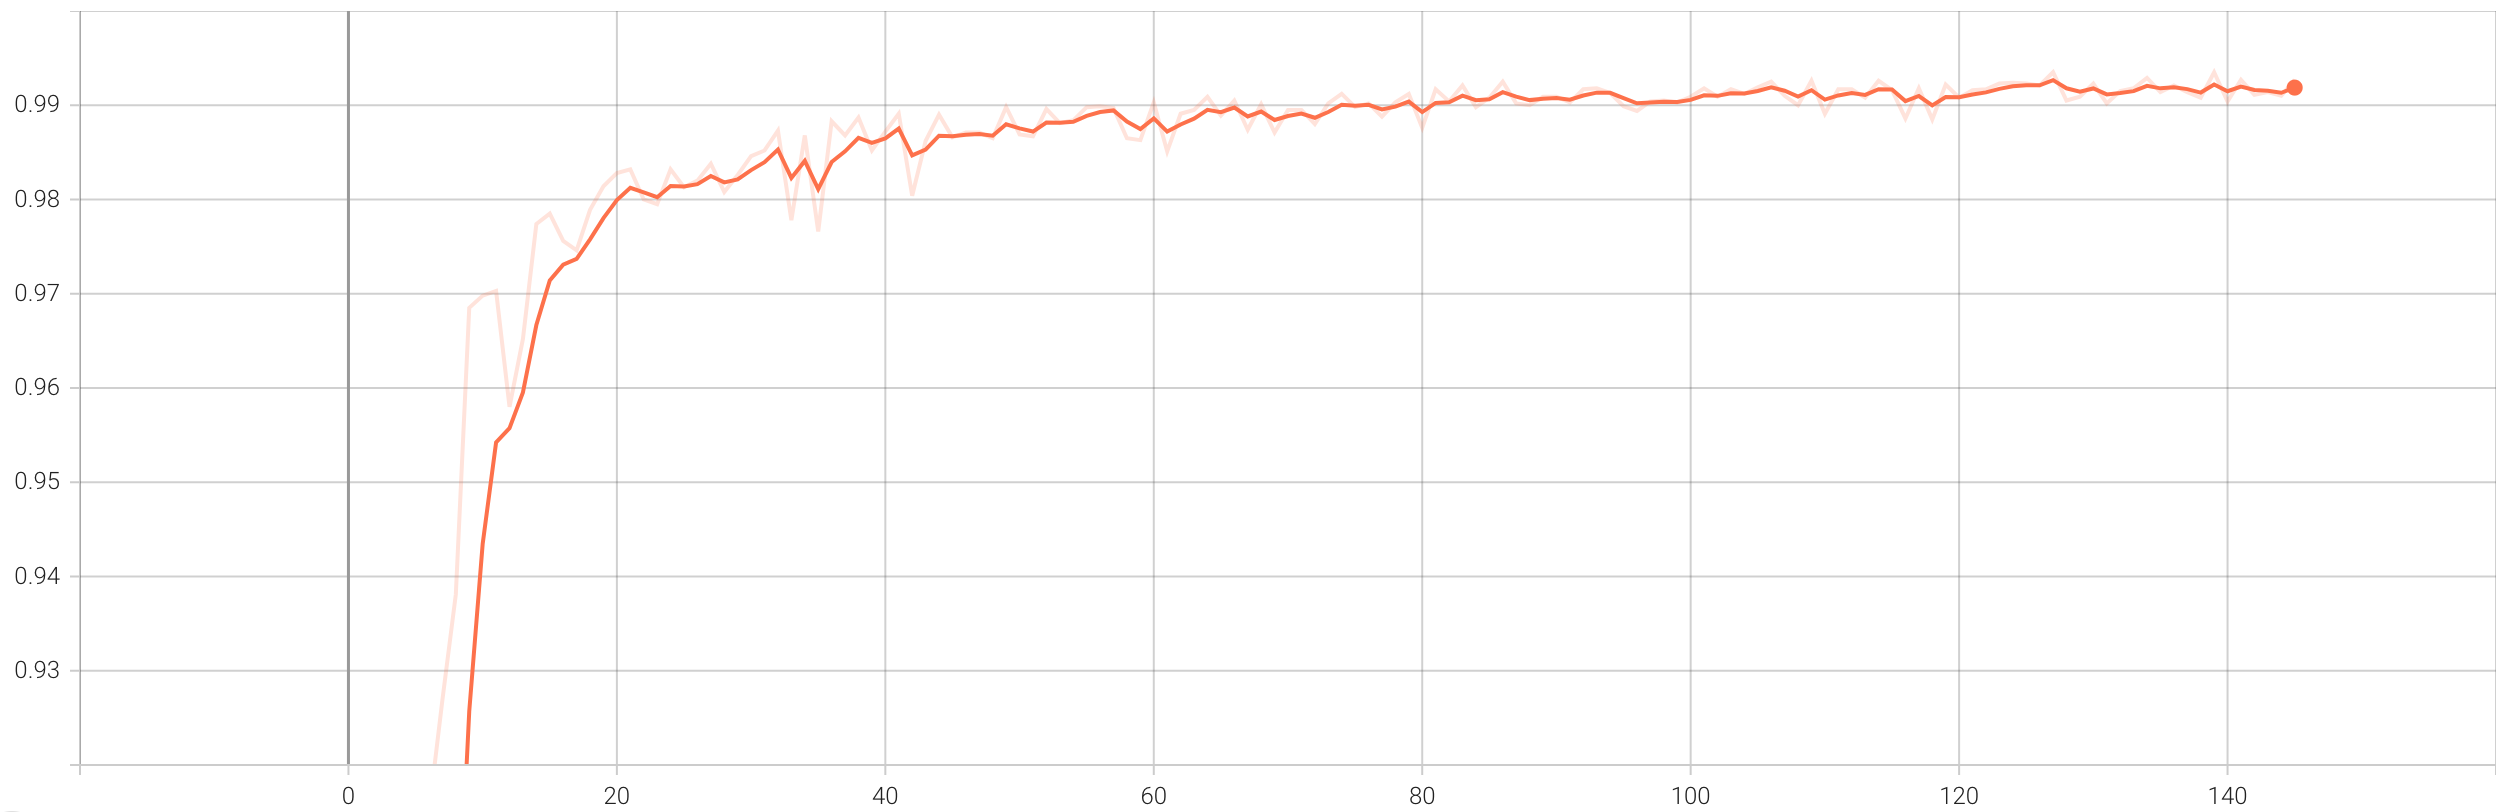

4. CapsNet test accuracy


In [195]:
display(Image('./Data/train_curves/shiftedmnist_train_loss_256.png', height=256, width=256))
print('1. CapsNet train loss')
display(Image('./Data/train_curves/shiftedmnist_eval_loss_256.png', height=256, width=256))
print('2. CapsNet eval loss')
display(Image('./Data/train_curves/shiftedmnist_train_acc_256.png', height=384, width=768))
print('3. CapsNet train accuracy')
display(Image('./Data/train_curves/shiftedmnist_test_acc_256.png', height=384, width=768))
print('4. CapsNet test accuracy')

Now we prepare to load and evaluate the model on MNIST test dataset

In [202]:
# model loading
model_path_orig = 'saved_model/best_models/mnist_128_500/caps_net_mnist_500_109.pt'
model_path = 'saved_model/best_models/shiftedmnist_256_500/caps_net_shifted_mnist_500_139.pt'

# When using DDP, state dict adds module prefix to all parameters, 
# we need to remove these prefixes to load the model in non DDP environment
from collections import OrderedDict
import re

model_dict_orig = OrderedDict()
model_dict = OrderedDict()
pattern = re.compile('module.')

state_dict_orig = torch.load(model_path_orig, map_location=torch.device('cpu'))
state_dict = torch.load(model_path, map_location=torch.device('cpu'))

for k,v in state_dict_orig.items():
    if re.search("module", k):
        model_dict_orig[re.sub(pattern, '', k)] = v
    else:
        model_dict_orig = state_dict_orig
        
for k,v in state_dict.items():
    if re.search("module", k):
        model_dict[re.sub(pattern, '', k)] = v
    else:
        model_dict = state_dict

In [203]:
# instantiate model 
from Caps_Net_MNIST_DP import MNISTCapsuleNetworkModel
network_orig = MNISTCapsuleNetworkModel()
from Caps_Net_ShiftedMNIST_DP import ShiftedMNISTCapsuleNetworkModel
network = ShiftedMNISTCapsuleNetworkModel()

# print model params
helper = Helper()
table, total_params = helper.count_parameters(network_orig)
print('CapsNet model:')
print(table)
print('Total trainable parameters: ', total_params)

# print model params
helper = Helper()
table, total_params = helper.count_parameters(network)
print('\n\nCapsNet model (for Shifted MNIST):')
print(table)
print('Total trainable parameters: ', total_params)

CapsNet model:
+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
|      conv1.weight     |   20736    |
|       conv1.bias      |    256     |
|      conv2.weight     |  5308416   |
|       conv2.bias      |    256     |
| digit_capsules.weight |  1474560   |
|    decoder.0.weight   |   81920    |
|     decoder.0.bias    |    512     |
|    decoder.2.weight   |   524288   |
|     decoder.2.bias    |    1024    |
|    decoder.4.weight   |   802816   |
|     decoder.4.bias    |    784     |
+-----------------------+------------+
Total trainable parameters:  8215568


CapsNet model (for Shifted MNIST):
+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
|      conv1.weight     |   20736    |
|       conv1.bias      |    256     |
|      conv2.weight     |  5308416   |
|       conv2.bias      |    256     |
| digit_capsules.weight |  5898240   |
|    decoder.0

In [209]:
# load model weights and evaluate
network_orig.load_state_dict(model_dict_orig)
network_orig.to(dev)
# put network on eval mode
network_orig.eval()

# load model weights and evaluate
network.load_state_dict(model_dict)
network.to(dev)
# put network on eval mode
network.eval()

ShiftedMNISTCapsuleNetworkModel(
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  (digit_capsules): Routing(
    (softmax): Softmax(dim=1)
  )
  (decoder): Sequential(
    (0): Linear(in_features=160, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1600, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
# load affNIST test dataset
from affNIST import getDataset


#evaluate the orig CapsNet model
test_loader = torch.utils.data.DataLoader(getDataset(isResized=True), batch_size=128)
count = 0
wrong_count = 0
progress_count=0
for batch_idx, (data, target) in enumerate(test_loader):
    data = data.float()
    data = data.to(dev)
    target = target.to(dev)
    _,reconstructions, preds = network_orig.forward(data)
    count += torch.sum(preds == target).detach().item()
    
    progress_count+=1
    if progress_count%100==0:
        print('Completed ', progress_count)
    
accuracy = float(count) / len(test_loader.dataset)
print('CapsNet (orig) accuracy on affNIST test set:', accuracy*100, '%')


#evaluate the CapsNet model trained on ShiftedMNIST
test_loader = torch.utils.data.DataLoader(getDataset(isResized=False), batch_size=128)
count = 0
wrong_count = 0
progress_count=0
for batch_idx, (data, target) in enumerate(test_loader):
    data = data.float()
    data = data.to(dev)
    target = target.to(dev)
    _,reconstructions, preds = network.forward(data)
    count += torch.sum(preds == target).detach().item()
    
    progress_count+=1
    if progress_count%100==0:
        print('Completed ', progress_count)
    
accuracy = float(count) / len(test_loader.dataset)
print('CapsNet (trained on Shifted MNIST) accuracy on affNIST test set:', accuracy*100, '%')

Images shape (320000, 40, 40, 1)
